In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [2]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
#ds = xr.open_dataset('~/RAPID/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros

ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc')

# ds.close() # how to close a dataset 

In [3]:
# for exporting some of the topography variables to make a QGIS map
# ds_wgs84 = ds.rio.reproject("EPSG:4326")
# ds_wgs84[['baf_ridge','aspect','dah','dah_binary','dem','tpi','slope']].to_netcdf('cer_treatment_region_dataset_topo_variables_4326.nc')

---

In [4]:
ds

<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 ...
Data variables: (12/339)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    baf_old                           (band, y, x) float32 ...
    baf_new                           (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 ...

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

Figure showing snow depths from the two years, and difference in snow depths

(-1.0, 1.0)

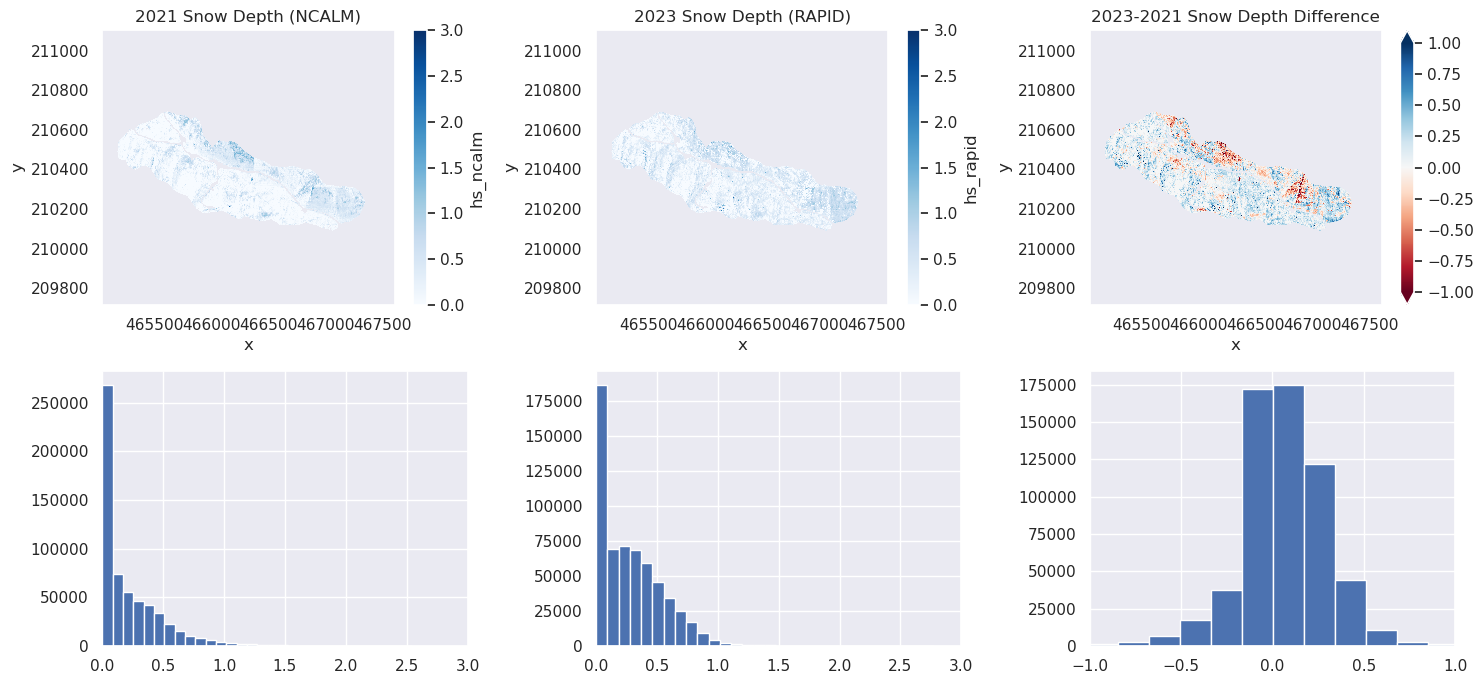

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

ds['hs_ncalm'].plot(ax=ax1, vmin=0, vmax=3, cmap='Blues')
ds['hs_rapid'].plot(ax=ax2, vmin=0, vmax=3, cmap='Blues')
(ds['hs_rapid']-ds['hs_ncalm']).plot(ax=ax3, vmin=-1, vmax=1, cmap='RdBu')

ax1.set_title('2021 Snow Depth (NCALM)')
ax2.set_title('2023 Snow Depth (RAPID)')
ax3.set_title('2023-2021 Snow Depth Difference');

ax4.hist(ds['hs_ncalm'].values.ravel(), bins=30)
ax5.hist(ds['hs_rapid'].values.ravel(), bins=30)
ax6.hist((ds['hs_rapid']-ds['hs_ncalm']).values.ravel(), bins=30)

ax4.set_xlim((0,3))
ax5.set_xlim((0,3))
ax6.set_xlim((-1,1))

Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [7]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

Figure showing snow depths from the two years, and difference in snow depths, now with all areas where snow depth = 0 removed

(-1.0, 1.0)

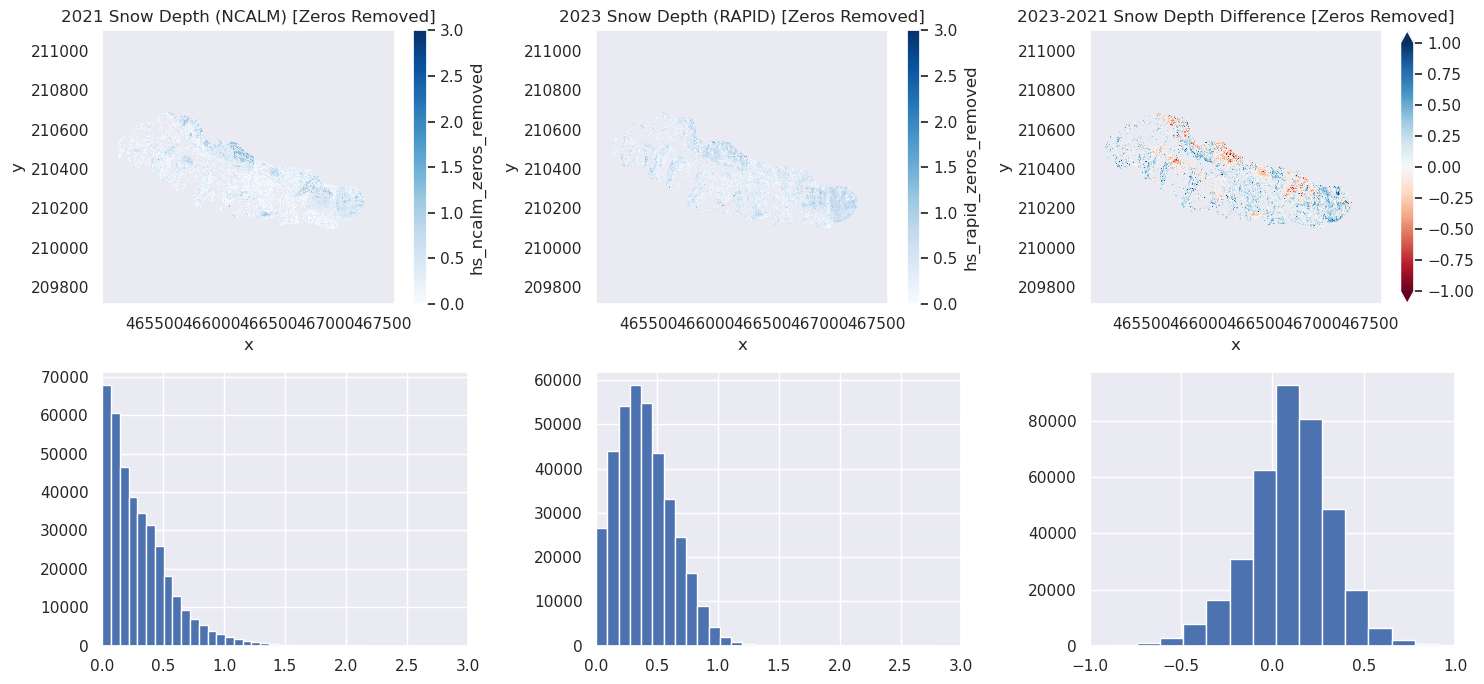

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

ds['hs_ncalm_zeros_removed'].plot(ax=ax1, vmin=0, vmax=3, cmap='Blues')
ds['hs_rapid_zeros_removed'].plot(ax=ax2, vmin=0, vmax=3, cmap='Blues')
(ds['hs_rapid_zeros_removed']-ds['hs_ncalm_zeros_removed']).plot(ax=ax3, vmin=-1, vmax=1, cmap='RdBu')

ax1.set_title('2021 Snow Depth (NCALM) [Zeros Removed]')
ax2.set_title('2023 Snow Depth (RAPID) [Zeros Removed]')
ax3.set_title('2023-2021 Snow Depth Difference [Zeros Removed]');

ax4.hist(ds['hs_ncalm_zeros_removed'].values.ravel(), bins=30)
ax5.hist(ds['hs_rapid_zeros_removed'].values.ravel(), bins=30)
ax6.hist((ds['hs_rapid_zeros_removed']-ds['hs_ncalm_zeros_removed']).values.ravel(), bins=30)

ax4.set_xlim((0,3))
ax5.set_xlim((0,3))
ax6.set_xlim((-1,1))

Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [53]:
#.where(np.isnan(ds.baf))
#.where(np.isnan(ds.baf))

ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Plot SDV from both years in the "control" areas only, we hope to see not much of a change in SDV

Text(0.5, 0.98, '"Control" Areas Only')

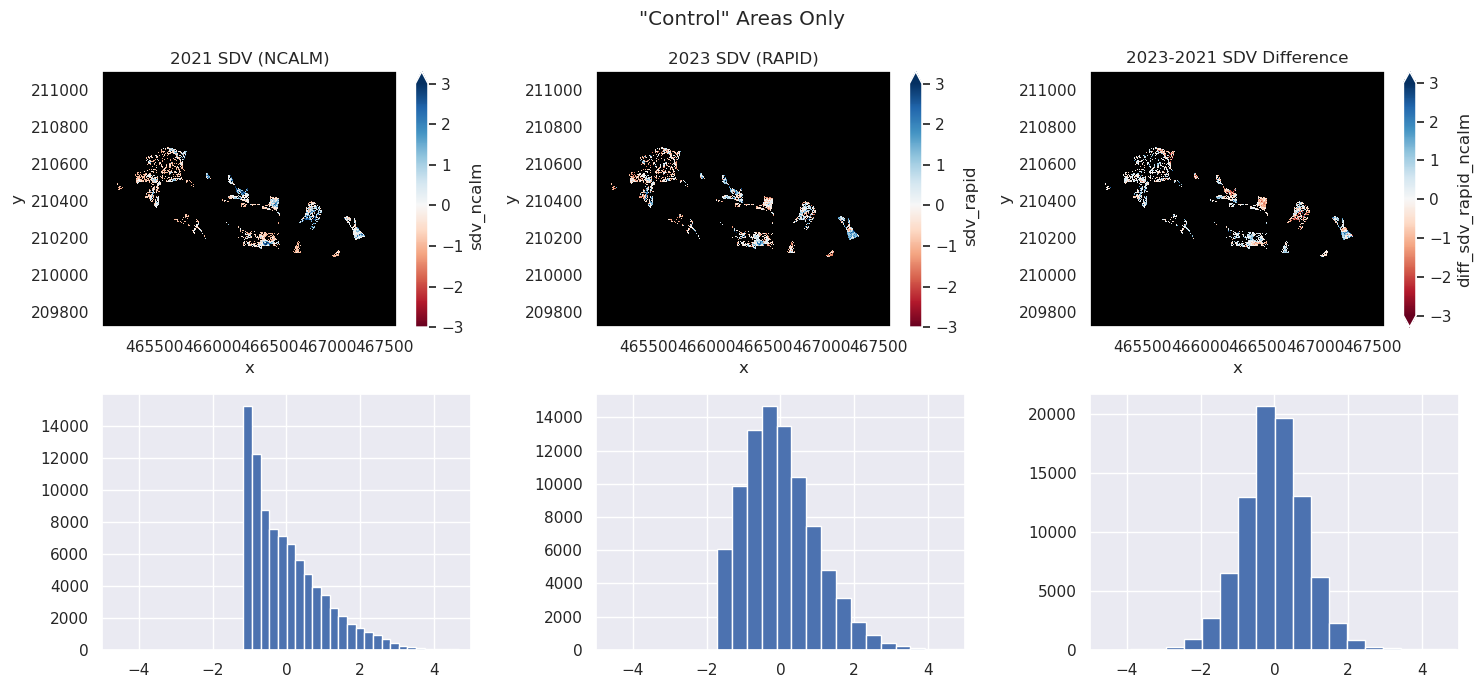

In [54]:
sdv_ncalm_here = ds['sdv_ncalm'].where(np.isnan(ds.baf))
sdv_rapid_here = ds['sdv_rapid'].where(np.isnan(ds.baf))
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), bins=30)
ax6.hist(sdv_diff_here.values.ravel(), bins=30)

ax4.set_xlim((-5,5))
ax5.set_xlim((-5,5))
ax6.set_xlim((-5,5))
fig.suptitle('"Control" Areas Only')

Now look at SDV in the "treatment" areas only, this is where we expect a change might occur

Text(0.5, 0.98, '"Treatment" Areas Only')

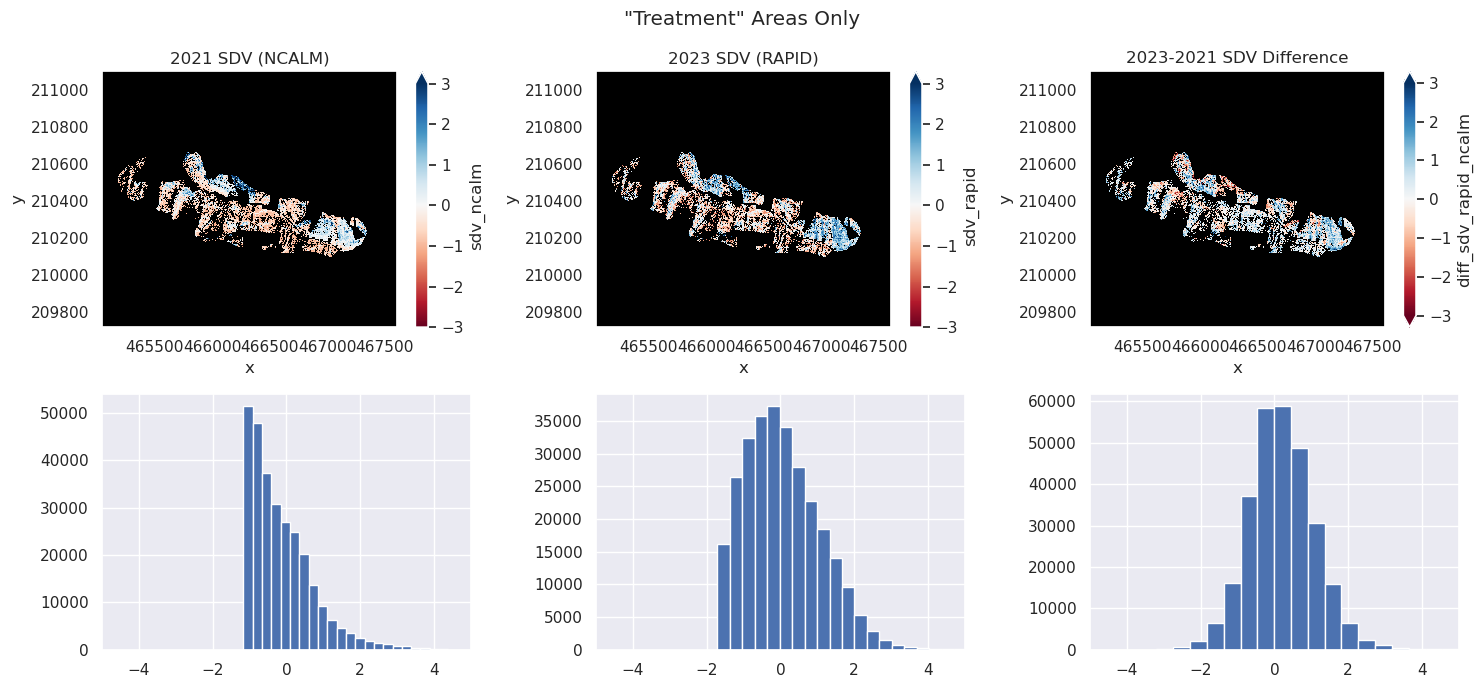

In [55]:
sdv_ncalm_here = ds['sdv_ncalm'].where(~np.isnan(ds.baf))
sdv_rapid_here = ds['sdv_rapid'].where(~np.isnan(ds.baf))
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), bins=30)
ax6.hist(sdv_diff_here.values.ravel(), bins=30)

ax4.set_xlim((-5,5))
ax5.set_xlim((-5,5))
ax6.set_xlim((-5,5))
fig.suptitle('"Treatment" Areas Only')

Also, we can look at all areas ("control" and "treatment")

Text(0.5, 0.98, '"Control" and "Treatment" Areas')

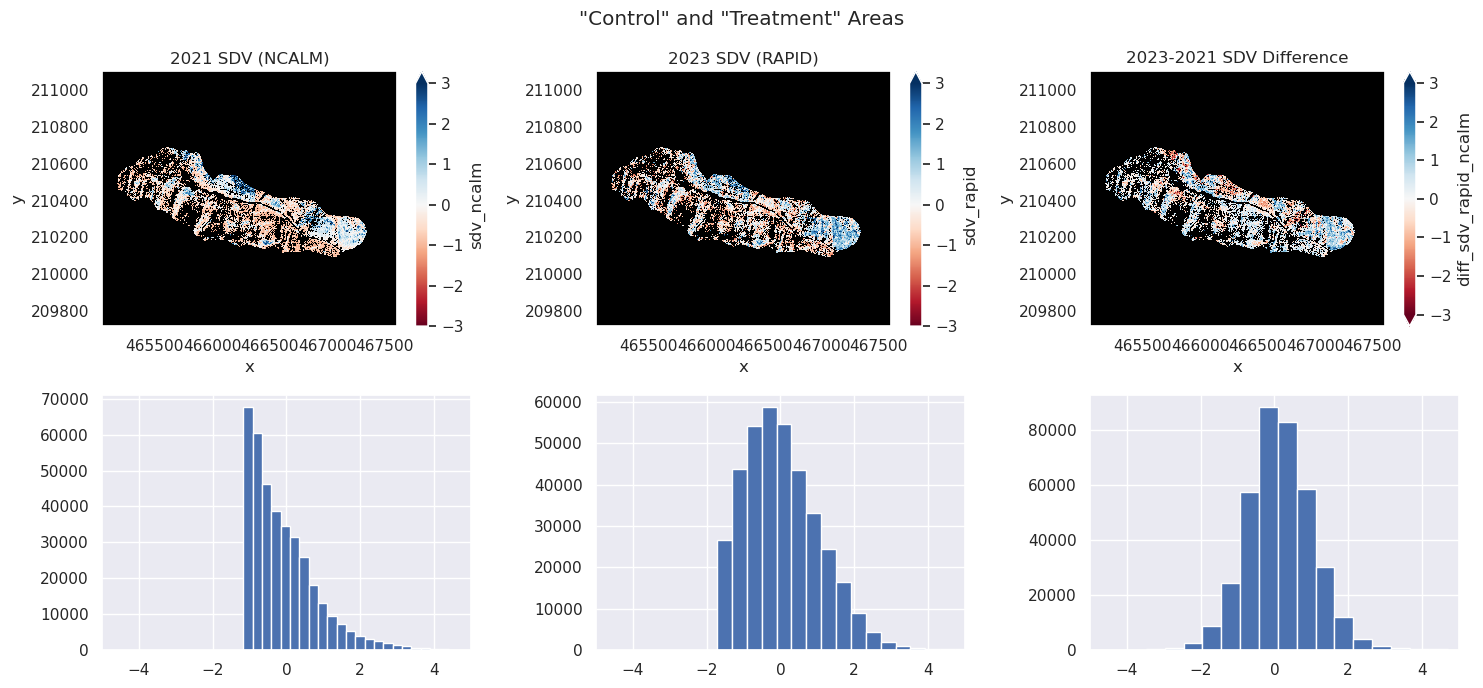

In [56]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

ds['sdv_ncalm'].plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
ds['sdv_rapid'].plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
ds['diff_sdv_rapid_ncalm'].plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(ds['sdv_ncalm'].values.ravel(), bins=30)
ax5.hist(ds['sdv_rapid'].values.ravel(), bins=30)
ax6.hist(ds['diff_sdv_rapid_ncalm'].values.ravel(), bins=30)

ax4.set_xlim((-5,5))
ax5.set_xlim((-5,5))
ax6.set_xlim((-5,5))
fig.suptitle('"Control" and "Treatment" Areas')

Treatment areas separated by side of the ridge

Text(0.5, 0.98, '"Treatment" Areas Only, Ridge South')

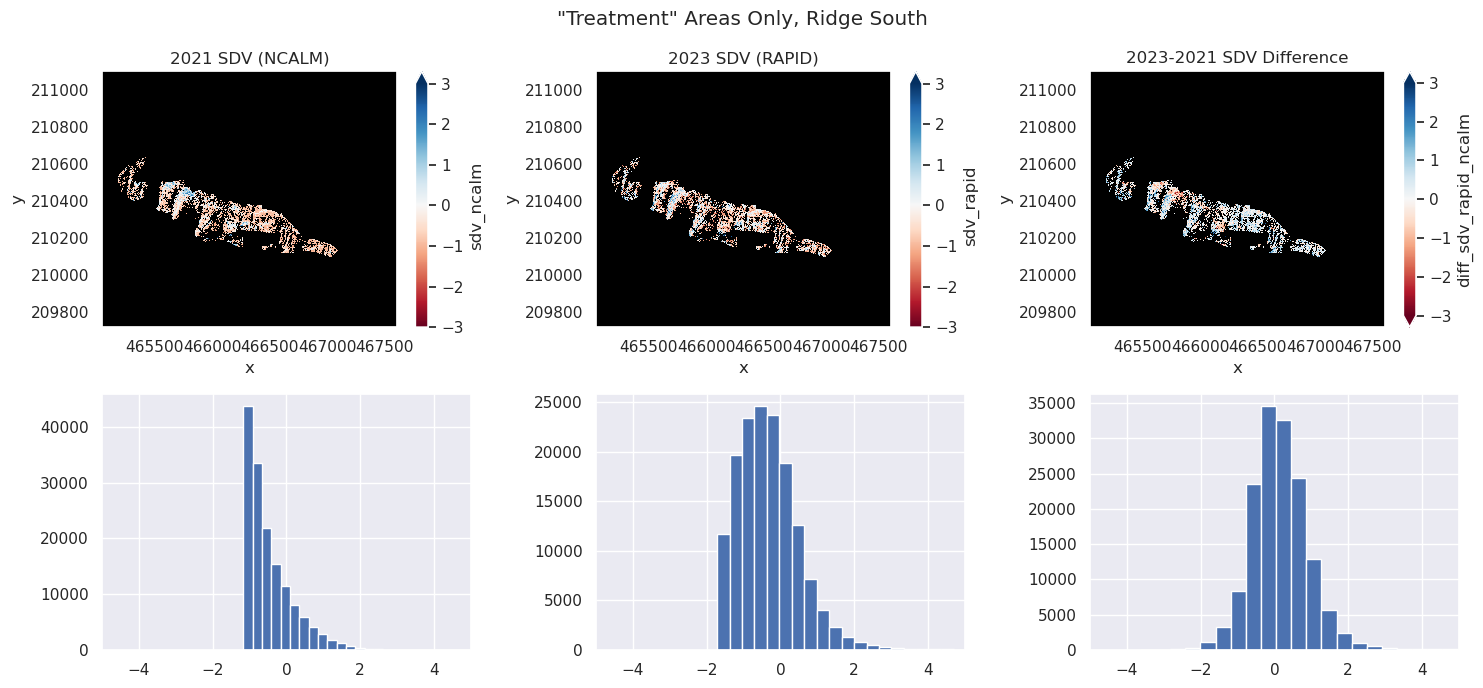

In [57]:
sdv_ncalm_here = ds['sdv_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_rapid_here = ds['sdv_rapid'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), bins=30)
ax6.hist(sdv_diff_here.values.ravel(), bins=30)

ax4.set_xlim((-5,5))
ax5.set_xlim((-5,5))
ax6.set_xlim((-5,5))
fig.suptitle('"Treatment" Areas Only, Ridge South')

Text(0.5, 0.98, '"Treatment" Areas Only, Ridge North')

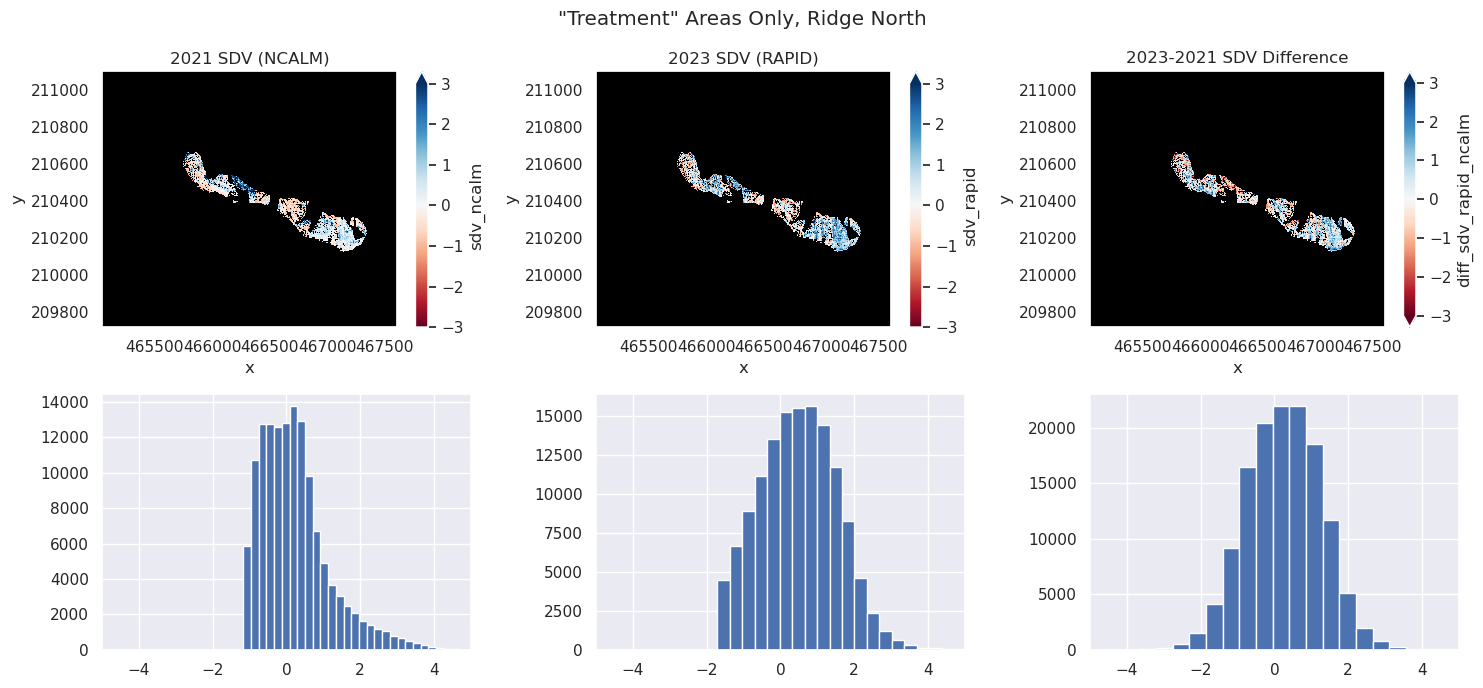

In [58]:

sdv_ncalm_here = ds['sdv_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_rapid_here = ds['sdv_rapid'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_diff_here = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

[ax1, ax2, ax3, ax4, ax5, ax6] = axs.ravel()

sdv_ncalm_here.plot(ax=ax1, vmin=-3, vmax=3, cmap='RdBu')
sdv_rapid_here.plot(ax=ax2, vmin=-3, vmax=3, cmap='RdBu')
sdv_diff_here.plot(ax=ax3, vmin=-3, vmax=3, cmap='RdBu')
for this_ax in [ax1, ax2, ax3]:
    this_ax.set_facecolor("black")

ax1.set_title('2021 SDV (NCALM)')
ax2.set_title('2023 SDV (RAPID)')
ax3.set_title('2023-2021 SDV Difference');

ax4.hist(sdv_ncalm_here.values.ravel(), bins=30)
ax5.hist(sdv_rapid_here.values.ravel(), bins=30)
ax6.hist(sdv_diff_here.values.ravel(), bins=30)

ax4.set_xlim((-5,5))
ax5.set_xlim((-5,5))
ax6.set_xlim((-5,5))
fig.suptitle('"Treatment" Areas Only, Ridge North')

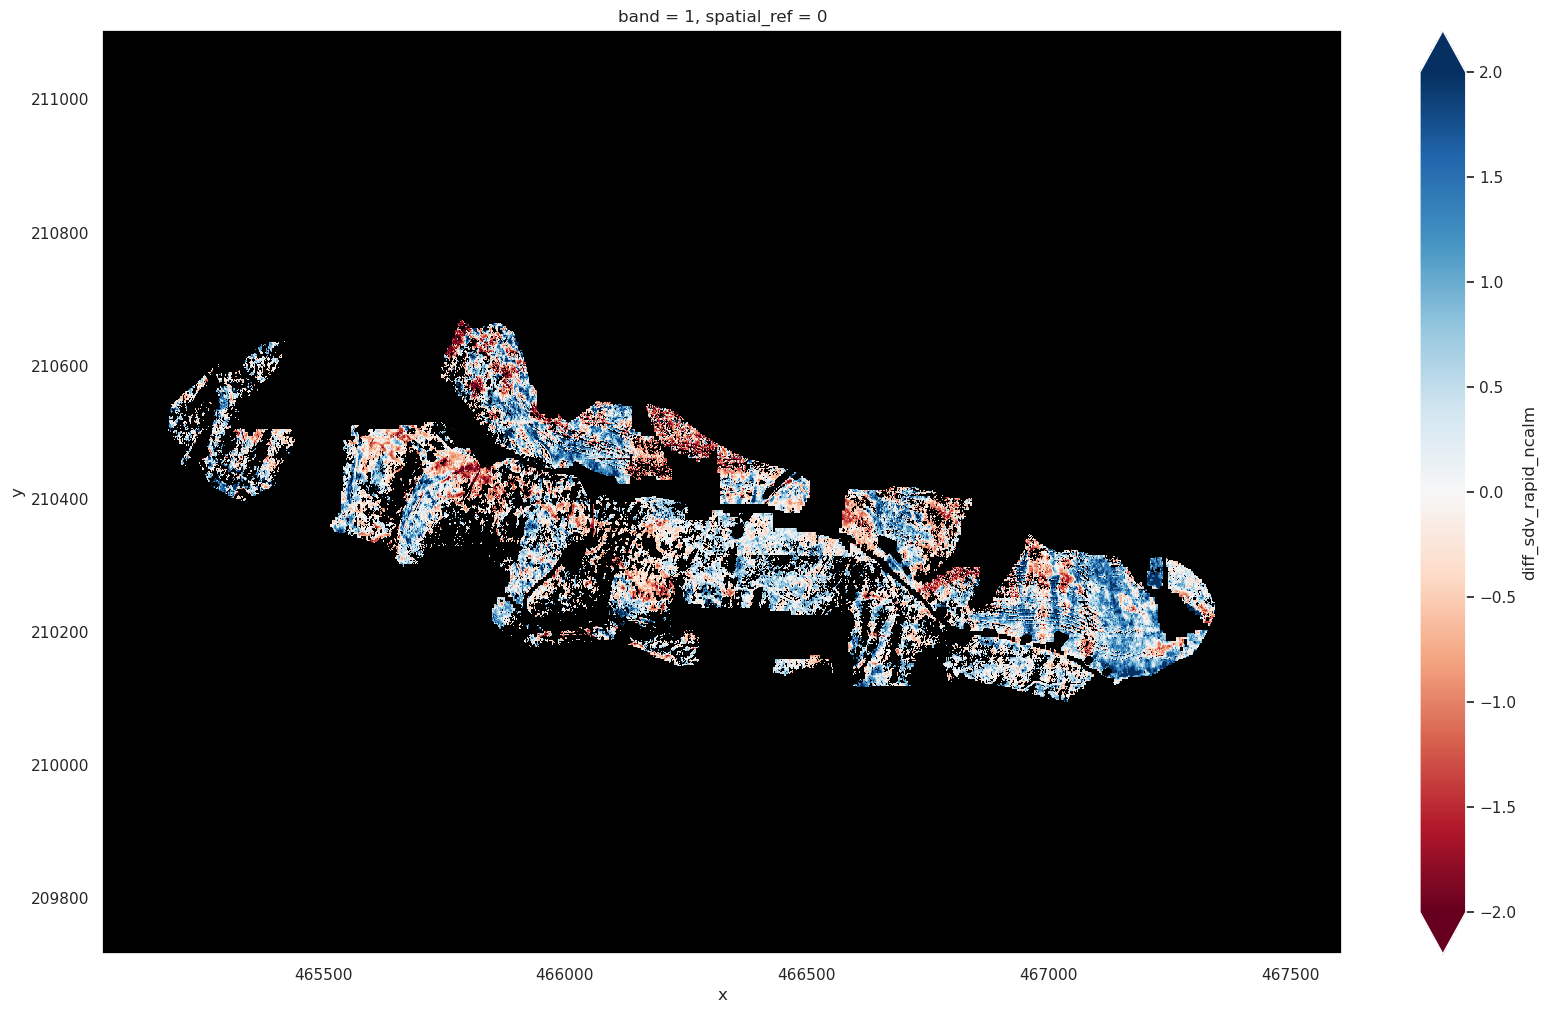

In [59]:
# Treatment areas only
plt.figure(figsize=(20,12))
ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).plot(vmin=-2, vmax=2, cmap='RdBu')
plt.gca().set_facecolor("black")

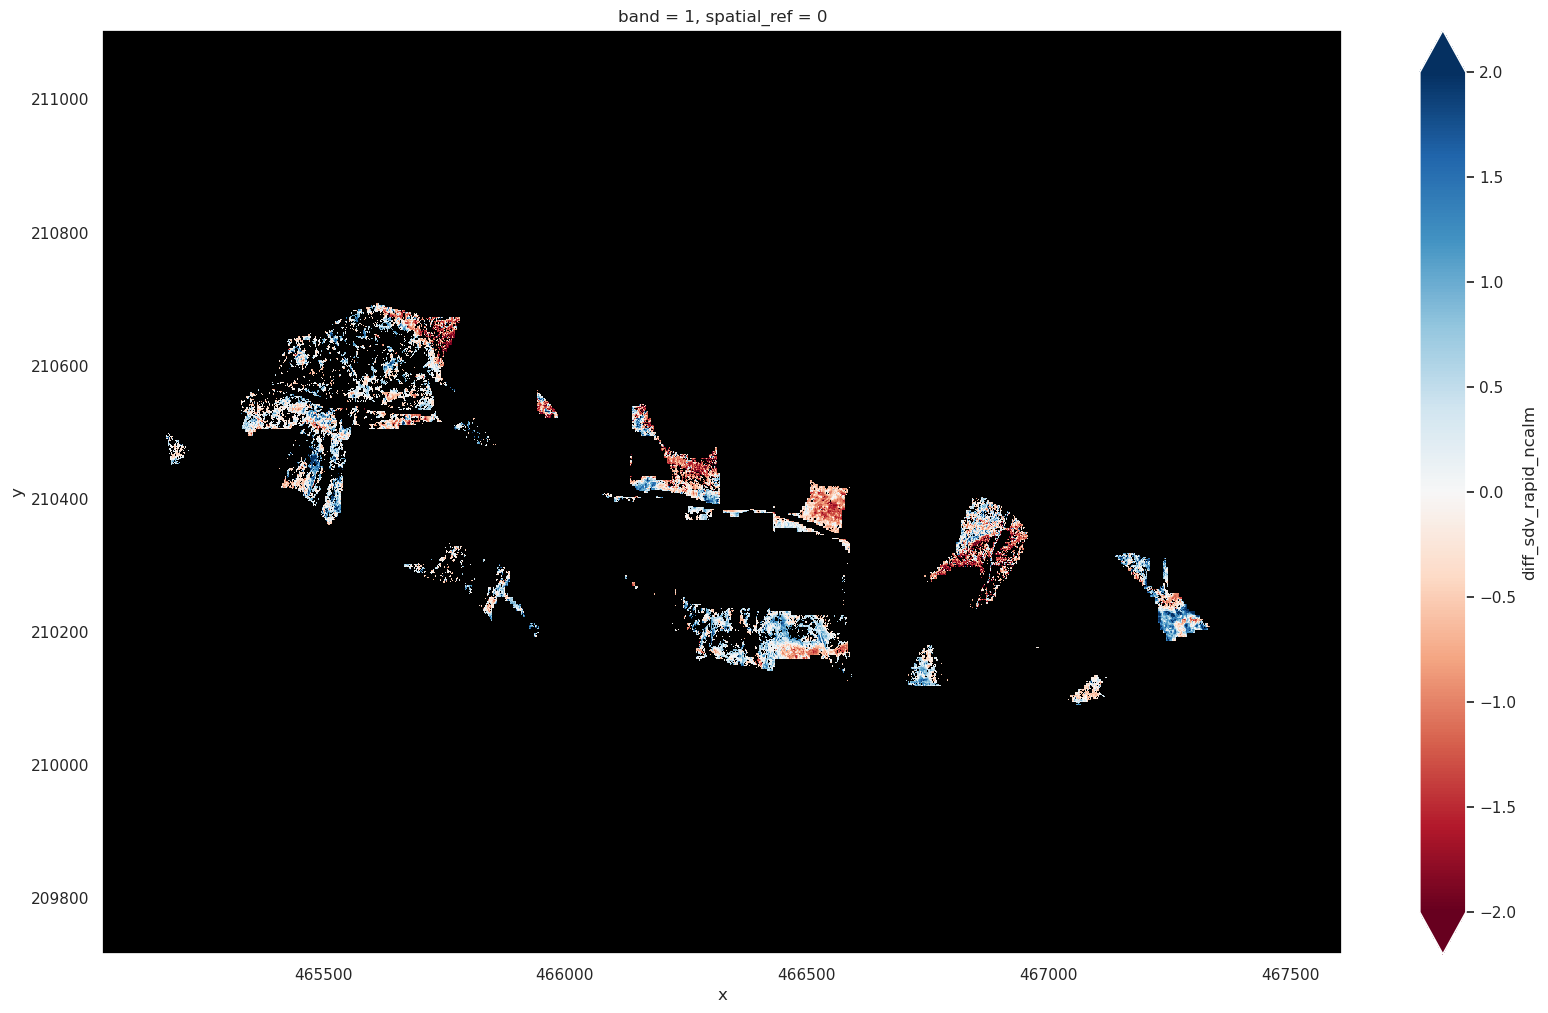

In [60]:
# Control areas only
plt.figure(figsize=(20,12))
ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).plot(vmin=-2, vmax=2, cmap='RdBu')
plt.gca().set_facecolor("black")

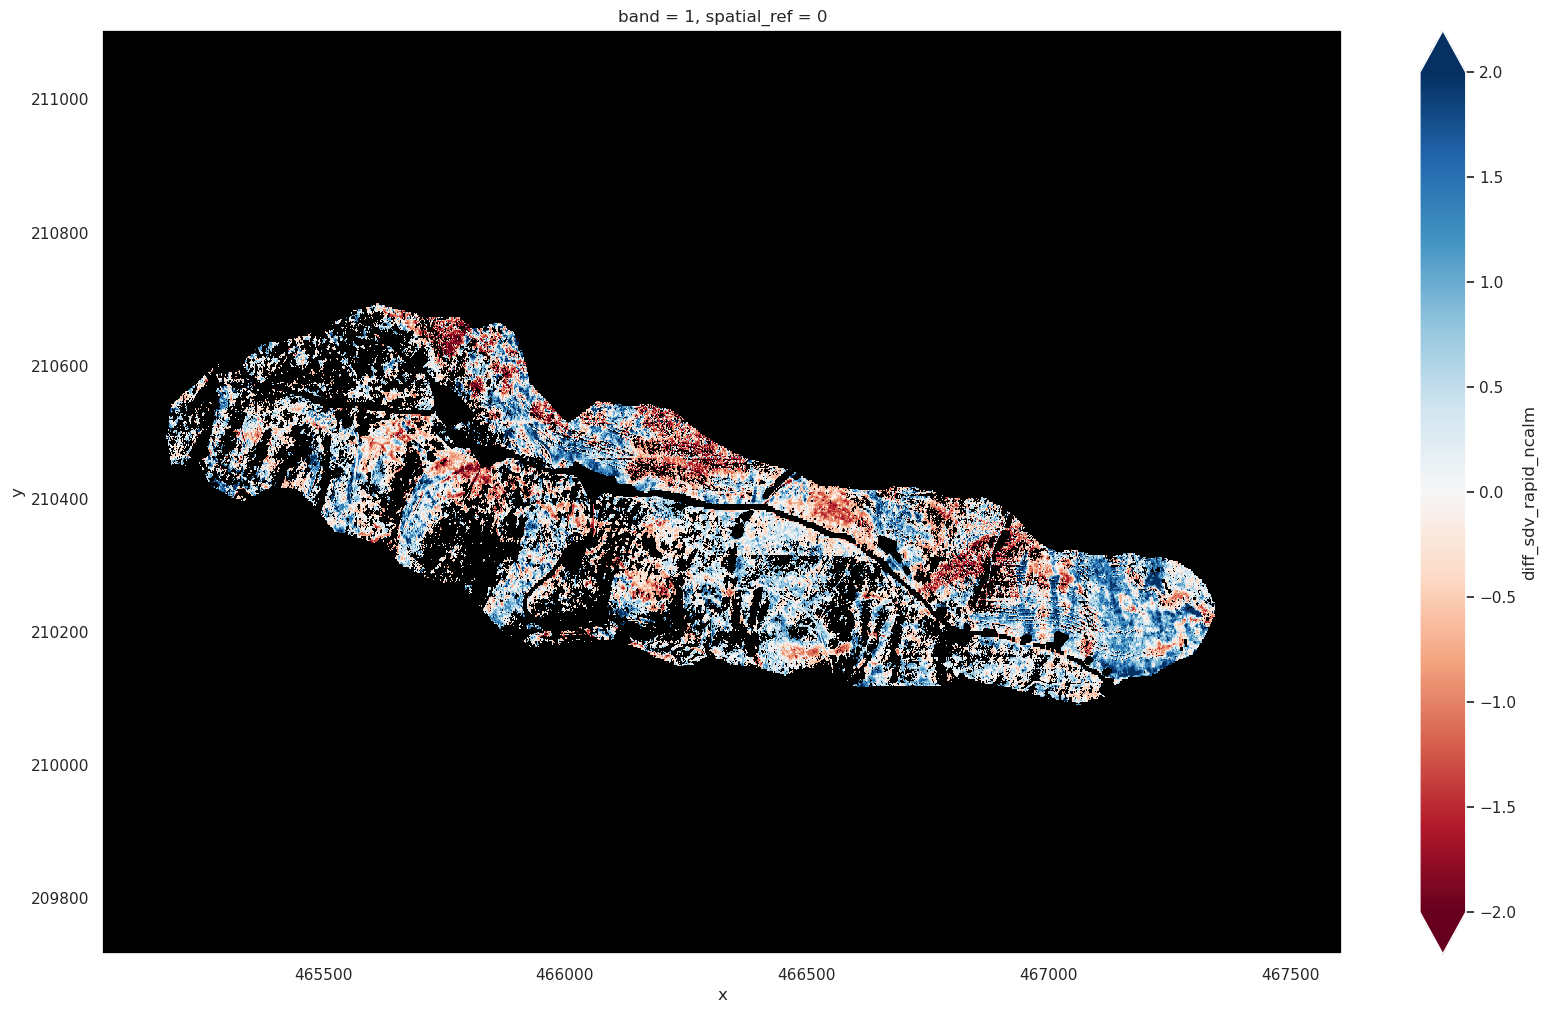

In [61]:
# everywhere
plt.figure(figsize=(20,12))
ds['diff_sdv_rapid_ncalm'].plot(vmin=-2, vmax=2, cmap='RdBu')
plt.gca().set_facecolor("black")

Text(0.5, 1.0, 'SDV Differences (2023 - 2021)\nNorth Slopes (DAH < 0)')

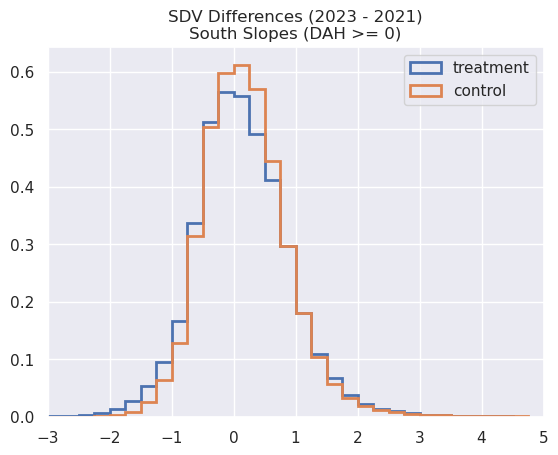

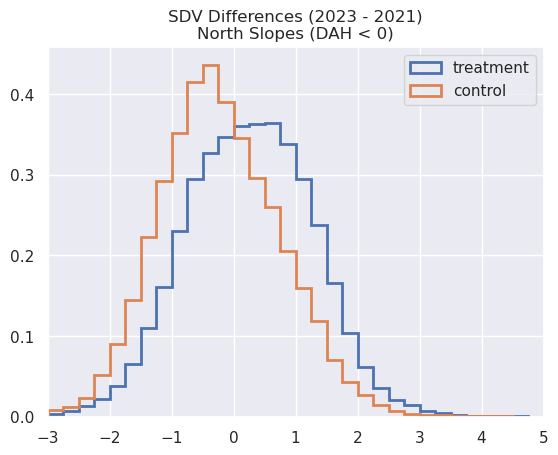

In [62]:
sdv_diff_treatments_south = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_treatments_north = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
sdv_diff_control_south = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
sdv_diff_control_north = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)


bins = np.arange(-3,5,0.25)

fig, ax = plt.subplots()
ax.hist(sdv_diff_treatments_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='treatment') # treatment
ax.hist(sdv_diff_control_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='control') # control
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\nSouth Slopes (DAH >= 0)')

fig, ax = plt.subplots()
ax.hist(sdv_diff_treatments_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='treatment') # treatment
ax.hist(sdv_diff_control_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='control') # control 
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\nNorth Slopes (DAH < 0)')

mean sdv_diff_north:  0.14
median sdv_diff_north:  0.13
mean sdv_diff_south:  0.16
median sdv_diff_south:  0.11


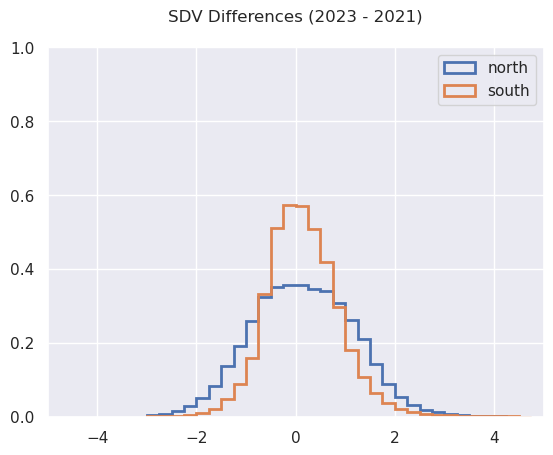

In [63]:
sdv_diff_north = ds['diff_sdv_rapid_ncalm'].where(ds.baf_ridge == -1)
sdv_diff_south = ds['diff_sdv_rapid_ncalm'].where(ds.baf_ridge == 1)


bins = np.arange(-3,5,0.25)

fig, ax = plt.subplots()
ax.hist(sdv_diff_north.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='north') # n
ax.hist(sdv_diff_south.values.ravel(), bins=bins, alpha=1, density=True, histtype='step', lw=2, label='south') # s
ax.set_xlim((-3,5))
plt.legend()
plt.title('SDV Differences (2023 - 2021)\n')

ax.set_ylim((0,1))
ax.set_xlim((-5,5))

print(f'mean sdv_diff_north: ', np.round(sdv_diff_north.mean().values,2))
print(f'median sdv_diff_north: ', np.round(sdv_diff_north.median().values,2))
print(f'mean sdv_diff_south: ', np.round(sdv_diff_south.mean().values,2))
print(f'median sdv_diff_south: ', np.round(sdv_diff_south.median().values,2))

**normalize snow depth between ncalm and rapid**\
standardized depth values\
take the snow depth maps, and describe the # of standard deviations the depth is from the mean value across the area\
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010WR009434

In [132]:
# I'm not sure if we need this or not yet, for the entire sample, making for now
ds['sum_hs_rapid_ncalm'] = ds['hs_rapid'] + ds['hs_ncalm']

In [13]:
# SVD = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey
ds['sdv_rapid'] = (ds['hs_rapid'] - ds['hs_rapid'].mean(dim=['x','y'])) / ds['hs_rapid'].std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm'] - ds['hs_ncalm'].mean(dim=['x','y'])) / ds['hs_ncalm'].std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm'])

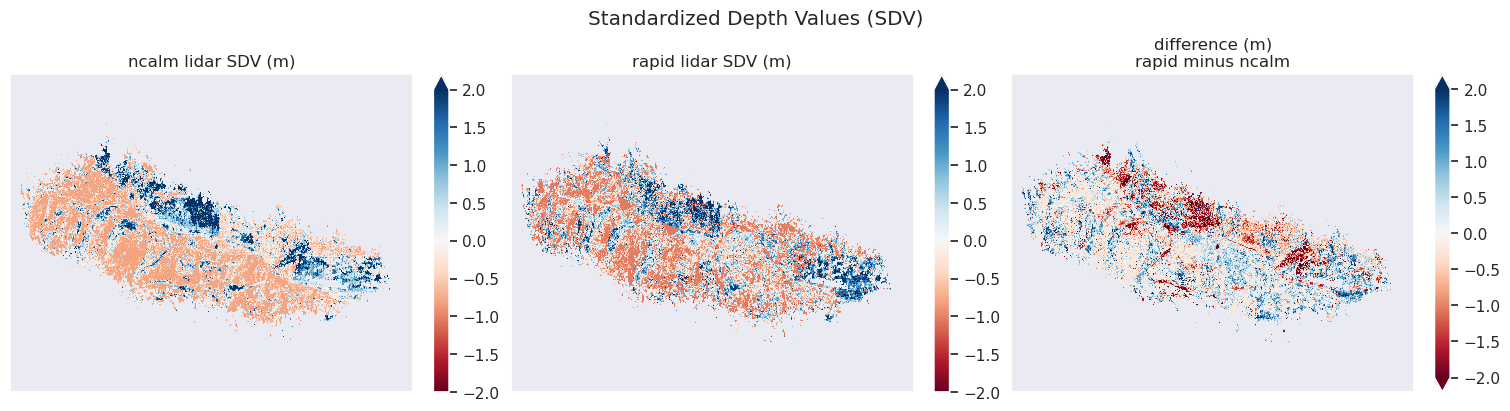

In [14]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,4), constrained_layout = True)
ds['sdv_ncalm'].plot(ax=axes[0], cmap='RdBu', vmin=-2, vmax=2, cbar_kwargs={'label': ''})
ds['sdv_rapid'].plot(ax=axes[1], cmap='RdBu', vmin=-2, vmax=2, cbar_kwargs={'label': ''})
ds['diff_sdv_rapid_ncalm'].plot(ax=axes[2], cmap='RdBu', vmin=-2, vmax=2, cbar_kwargs={'label': ''})

plt.suptitle('Standardized Depth Values (SDV)')
axes[0].set_title('ncalm lidar SDV (m)')
axes[1].set_title('rapid lidar SDV (m)')
axes[2].set_title('difference (m)\nrapid minus ncalm')

axes[0].set_xlabel('');axes[0].set_ylabel('');axes[0].set_xticks([]);axes[0].set_yticks([])
axes[1].set_xlabel('');axes[1].set_ylabel('');axes[1].set_xticks([]);axes[1].set_yticks([])
axes[2].set_xlabel('');axes[2].set_ylabel('');axes[2].set_xticks([]);axes[2].set_yticks([])

plt.show()


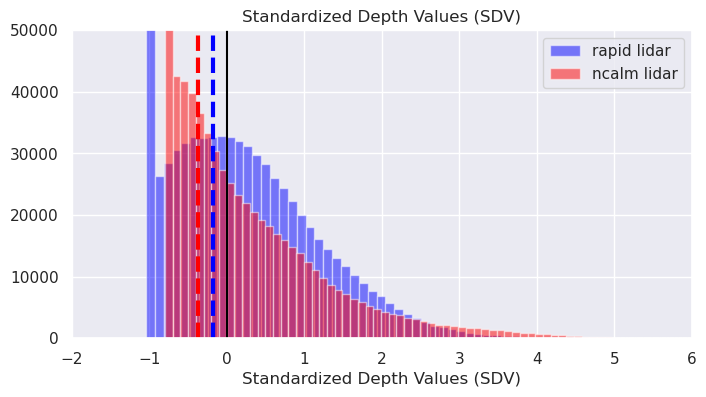

In [15]:
# plot histograms of the two svd depth values
fig, axes = plt.subplots(1, 1, figsize=(8,4))
ds['sdv_rapid'].plot.hist(bins=100, label='rapid lidar', alpha=.5, color='blue')
ds['sdv_ncalm'].plot.hist(bins=100, label='ncalm lidar', alpha=.5, color='red')

# plot their medians 
width=3
plt.axvline(ds['sdv_rapid'].median(), color='blue', linestyle='dashed', linewidth=width)
plt.axvline(ds['sdv_ncalm'].median(), color='red', linestyle='dashed', linewidth=width)

# plot the zero vertical line
plt.axvline(0, color='black')

plt.title('Standardized Depth Values (SDV)')
plt.xlabel('Standardized Depth Values (SDV)')
plt.legend()
plt.xlim(-2,6)
plt.ylim(0,50000)

plt.show()

We need to make all of these groups seperate variables to plot them in histograms together 

In [16]:
# RAPID
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['sdv_rapid_lidar_canopychange_dahneg'] = ds['sdv_rapid'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['sdv_rapid_lidar_canopychange_dahpos'] = ds['sdv_rapid'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['sdv_rapid_lidar_nocanopychange_dahneg'] = ds['sdv_rapid'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['sdv_rapid_lidar_nocanopychange_dahpos'] = ds['sdv_rapid'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['sdv_rapid_baf_canopychange_dahneg'] = ds['sdv_rapid'].where(ds['baf_canopychange_dahneg'].notnull())
ds['sdv_rapid_baf_canopychange_dahpos'] = ds['sdv_rapid'].where(ds['baf_canopychange_dahpos'].notnull())
ds['sdv_rapid_baf_nocanopychange_dahneg'] = ds['sdv_rapid'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['sdv_rapid_baf_nocanopychange_dahpos'] = ds['sdv_rapid'].where(ds['baf_nocanopychange_dahpos'].notnull())

# NCALM
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['sdv_ncalm_lidar_canopychange_dahneg'] = ds['sdv_ncalm'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['sdv_ncalm_lidar_canopychange_dahpos'] = ds['sdv_ncalm'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['sdv_ncalm_lidar_nocanopychange_dahneg'] = ds['sdv_ncalm'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['sdv_ncalm_lidar_nocanopychange_dahpos'] = ds['sdv_ncalm'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['sdv_ncalm_baf_canopychange_dahneg'] = ds['sdv_ncalm'].where(ds['baf_canopychange_dahneg'].notnull())
ds['sdv_ncalm_baf_canopychange_dahpos'] = ds['sdv_ncalm'].where(ds['baf_canopychange_dahpos'].notnull())
ds['sdv_ncalm_baf_nocanopychange_dahneg'] = ds['sdv_ncalm'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['sdv_ncalm_baf_nocanopychange_dahpos'] = ds['sdv_ncalm'].where(ds['baf_nocanopychange_dahpos'].notnull())

KeyError: 'lidar_canopychange_dahneg'